|0> - the electronic ground state with ms=0
|1> - electronic ground state with ms =+-1
|2> - electronic excited state with ms=0
|3> - electronic excited state with ms=+-1
|4> - inter system crossing state


    % % %  % Energy level diagram % % % % 
    %                         ----- |e, ms=+-1;   3> % 
    %                                   % 
    %                                   % 
    % ----- |e, ms=0; 2>                         % 
    %                                   %
    %                                   %
    %             ------ |i.s. 4>            % 
    %                                   %
    %                                   %
    %                         ----- |g, ms=+-1, 1> %
    %                                   %
    % ----- |g, ms=0; 0>                         %
    % % % % % % % % % % % % % % % % % % %
    

In [1]:
import numpy as np

In [135]:
pump_rate = 1/32000000
WR = 1/100 *1/3000 # rabi frequency
plot_or_not = False

In [136]:
WR

3.3333333333333333e-06

In [137]:
hbar        = 1./(2*np.pi)
G10         = 1./3000000  # population decay from |1> to |0> %T1 ranges from 3 microseconds to 4 ms according to Eisuke's measurements on the E1304 sample
G01         = G10*np.exp(-2.87e9*4.13e-15/0.25e-3)            # population fluctuation from |0> to |1> (G01 = G10 e^(-dE/kbT))
G20         = 1./12         # population decay from |2> to |0> (12 ns (from light narrowing paper))
P02         = pump_rate    # 10*G20; % |0> to |2> pump rate, proportional to optical power
P13         = P02          # |1> to |3> pump rate, proportional to optical power
G31         = G20          # population decay from |3> to |1>
G34         = G20          # population decay from |3> to |4>  (Light narrowing paper says G34 = G31 = G20.)
G40         = 1./300        # population decay from |4> to |0> (300 ns)
t2star      = 3000
gamma       = 1./t2star     #  # dephasing rate (1/T2* process) (3000 ns from Kento's paper)
Hgub        = 0.036        # T/GHz planck/(g factor * bohr magneton)

photon_scale_constant = 5e6
num_detunings = 1E3

# initialize arrays
detunings = np.linspace(-gamma*10, gamma*10, int(num_detunings))

In [138]:
P02

3.125e-08

In [139]:
def M(d, gamma=gamma, rabi=WR):
    M = [[-P02-G01       ,    -(1j/hbar)*rabi/2    ,     (1j/hbar)*rabi/2     , G10    ,     G20  ,    0   ,  G40],
            [-(1j/hbar)*rabi/2  ,  -gamma+(1j/hbar)*d    ,   0   ,      (1j/hbar)*rabi/2 ,  0    ,    0   ,   0],
            [(1j/hbar)*rabi/2      ,        0      ,      -gamma-(1j/hbar)*d   ,   -(1j/hbar)*rabi/2 ,  0 ,  0   ,   0], 
            [G01          ,        (1j/hbar)*rabi/2     ,   -(1j/hbar)*rabi/2      ,    -P13-G10   ,    0 ,   G31  ,   0], 
            [P02           ,              0  , 0  , 0  ,  -G20 ,   0   ,   0], 
            [0              ,             0                      , 0  , P13   , 0    , -G34-G31 , 0],
            [1                 , 0            ,     0           ,   1    ,  1   ,  1    ,1]]
    return np.array(M)

In [140]:
def compute_pl(dt):
    steadystate = np.array([0,0,0,0,0,0,1]).reshape(-1,1)
    rho = np.linalg.inv(M(dt)).dot(steadystate)
    PL = np.real(G20*rho[5] + G31*rho[6])
    return PL

In [141]:
PL = np.array([compute_pl(dt) for dt in detunings])

In [142]:
PL = PL/PL.max()

In [143]:
import matplotlib.pyplot as plt

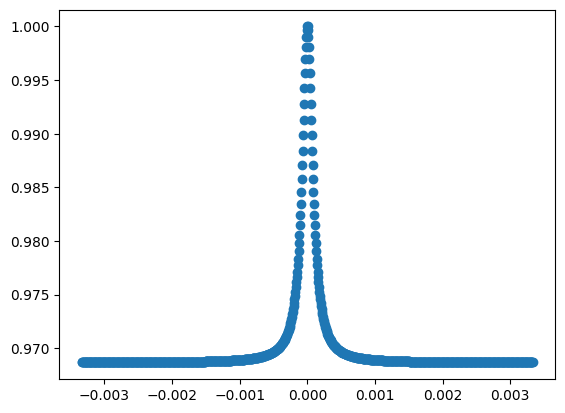

In [144]:
plt.scatter(detunings, PL[:,0])

In [145]:
from scipy import optimize
from scipy.optimize import leastsq
import scipy 
import nvmodels

In [146]:
def lorentz_plus_floor(x, center, amplitude, width, floor):
    return floor + nvmodels.utilities.lorentzian(x, center, amplitude, width)

In [147]:
p_opt, p_cov = scipy.optimize.curve_fit(lorentz_plus_floor, detunings, PL[:,0], p0=[0,1,.001, 0.5])

/Users/adam/miniconda3/envs/nvmodels/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


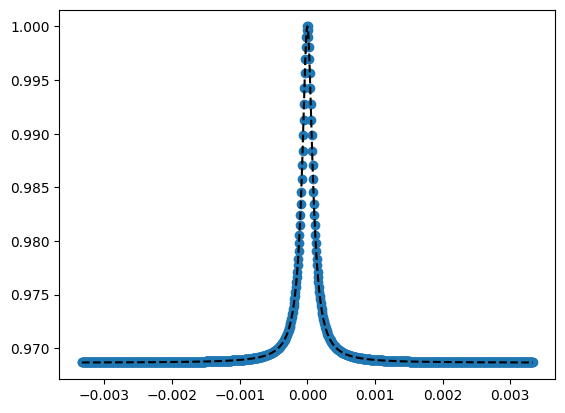

In [148]:
plt.scatter(detunings, PL[:,0])
plt.plot(detunings, lorentz_plus_floor(detunings, *p_opt), 'k--', label='Fit')

In [149]:
p_opt

array([2.65344188e-13, 3.14055751e-02, 9.14792508e-05, 9.68636151e-01])

In [150]:
np.max(lorentz_plus_floor(detunings, *p_opt)) - np.min(lorentz_plus_floor(detunings, *p_opt))

0.03134021311210555

In [ ]:
# notice that as the pump rate get's smaller (1/large number), the contrast above gets smaller
# which makes sense